In [1]:
# IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.reselience_metrics import (
    EvalWindows,
    to_performance,
    compute_all,
)


In [51]:
# === PATH TO YOUR RUN FILES (.npz) ===
PATH_PERT = "testv2/MacLight_Normal_Block/1_step_metrics.npz"     # run WITH perturbation
PATH_BASE = "testv2/MacLight_Normal_Normal/1_step_metrics.npz"              # control run WITHOUT perturbation

# time axis (must exist in BOTH files)
TIME_KEY = "t"

# Metric keys (one pair per performance metric you want to evaluate)
KEYMAP = {
    "speed":  ("speed", "speed"),        # (pert_key, base_key)
    "queue":  ("queue", "queue"),
    "wait":   ("wait", "wait"),
    "reward": ("ret", "ret"),
}

# Which metrics to evaluate in this run
SELECTED = ["speed", "queue", "wait"]  # or ["speed"] or add "reward" if meaningful

# === Windows (seconds or steps; must match your time units) ===
wins = EvalWindows(
    pre_start=0,  # start of pre-shock window
    t0=600,         # shock start
    t1=1800,         # shock end
    post_end=3600    # end of evaluation horizon
)

# Normalization rule baked in our util:
# - higher_is_better=True  -> minmax
# - higher_is_better=False -> inv1p
DIRECTION = {
    "speed":  True,   # higher is better
    "reward": True,   # often higher is better (if your reward is aligned that way)
    "queue":  False,  # lower is better
    "wait":   False,  # lower is better
}

EPISODE = 1
SEED = 45
SEEDS = [42,43,44,45,46]

In [53]:
def array_to_series(t: np.ndarray, x: np.ndarray) -> pd.Series:
    """Create a pandas Series indexed by time/step."""
    return pd.Series(x, index=t).sort_index()

In [54]:
# Load files
pert = np.load(PATH_PERT,allow_pickle=True)
base = np.load(PATH_BASE,allow_pickle=True)
# Load the step log dict
pert = pert["step_log"].item()
base = base["step_log"].item()



In [55]:
all_rows = []
for seed in SEEDS:
    # Extract time axes for this seed
    t_pert = pert[seed][EPISODE][TIME_KEY]
    t_base = base[seed][EPISODE][TIME_KEY]
    # Build series per metric for this seed
    series_pert = {}
    series_base = {}
    for name in SELECTED:
        k_pert, k_base = KEYMAP[name]
        x_pert = pert[seed][EPISODE][k_pert]
        x_base = base[seed][EPISODE][k_base]
        series_pert[name] = array_to_series(t_pert, x_pert)
        series_base[name] = array_to_series(t_base, x_base)
    # Compute resilience metrics per selected metric
    for name in SELECTED:
        higher_is_better = DIRECTION[name]
        # 1) Normalize perturbed run into performance P(t)
        P = to_performance(
            series_pert[name],
            higher_is_better=higher_is_better,
            ref_window=wins.pre,
            allow_clip=False
        )
        # 2) Compute resilience metrics using baseline raw series
        res = compute_all(
            P, wins,
            baseline_raw=series_base[name],
            higher_is_better=higher_is_better,
            target=0.9,    # RT90
            band=0.05
        )
        res["metric"] = name
        res["seed"] = seed
        all_rows.append(res)
# Per-seed results (one row per seed × metric)
results_df = pd.DataFrame(all_rows).set_index(["metric","seed"]).sort_index()
display(results_df)

auc_ratio  peak_loss  rt_target  residual_delta
metric seed                                                 
queue  42     0.944648   0.208506      160.0       -0.089662
       43     0.930272   0.211301      160.0       -0.072944
       44     0.969093   0.143638      220.0       -0.083857
       45     0.942224   0.164231      365.0       -0.091271
       46     0.970767   0.154719      160.0       -0.081944
speed  42     0.940540   0.381215       45.0       -0.058067
       43     0.864162   0.382833       45.0       -0.029002
       44     0.961836   0.328288        0.0       -0.041464
       45     0.906884   0.319926        0.0       -0.051025
       46     0.945521   0.355438        5.0       -0.039923
wait   42     0.931633   0.272183      200.0       -0.103634
       43     0.885002   0.434420      130.0       -0.083939
       44     0.954083   0.201646      220.0       -0.100458
       45     0.887366   0.381233      275.0       -0.114177
       46     0.973359   0.208516      200.0       -0.096234

In [56]:
# Show mean ± std across seeds for each metric (speed / queue / wait)
summary = (results_df
           .groupby("metric")
           .agg(["mean","std"])
           .round(3))
display(summary)

auc_ratio        peak_loss        rt_target         residual_delta  \
            mean    std      mean    std      mean     std           mean   
metric                                                                      
queue      0.951  0.018     0.176  0.031     213.0  88.854         -0.084   
speed      0.924  0.039     0.354  0.029      19.0  23.822         -0.044   
wait       0.926  0.039     0.300  0.104     205.0  51.962         -0.100   

               
          std  
metric         
queue   0.007  
speed   0.011  
wait    0.011

In [57]:
def plot_raw_overlay_simple(raw_pert, raw_base, wins, ylabel="", title=""):
    plt.figure(figsize=(15,8))
    plt.plot(raw_pert.index, raw_pert.values, label="Perturbed")
    plt.plot(raw_base.index, raw_base.values, label="Baseline")
    # shade perturbation window
    plt.axvspan(wins.t0, wins.t1, color="gray", alpha=0.3, label="Perturbation")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

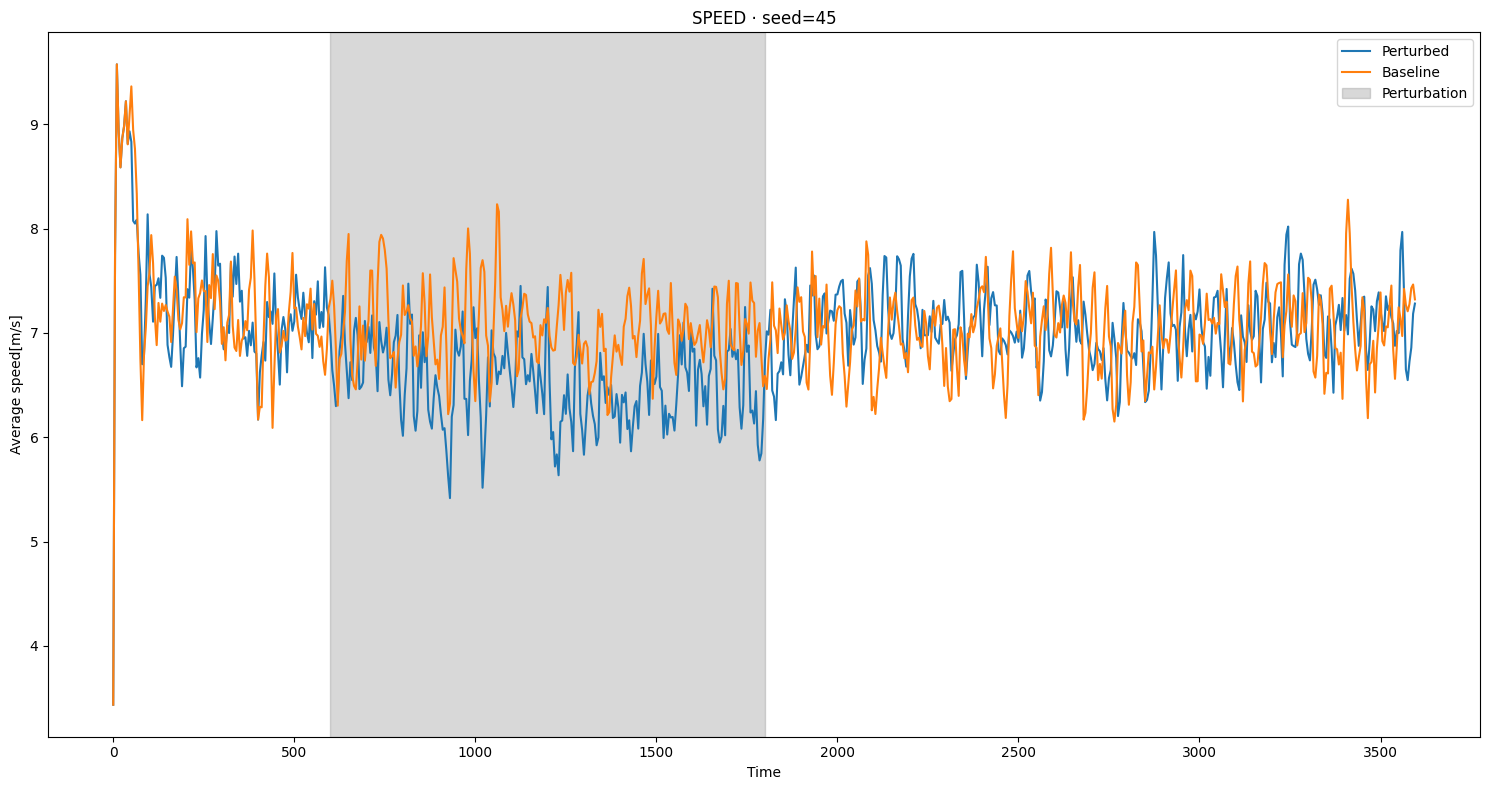

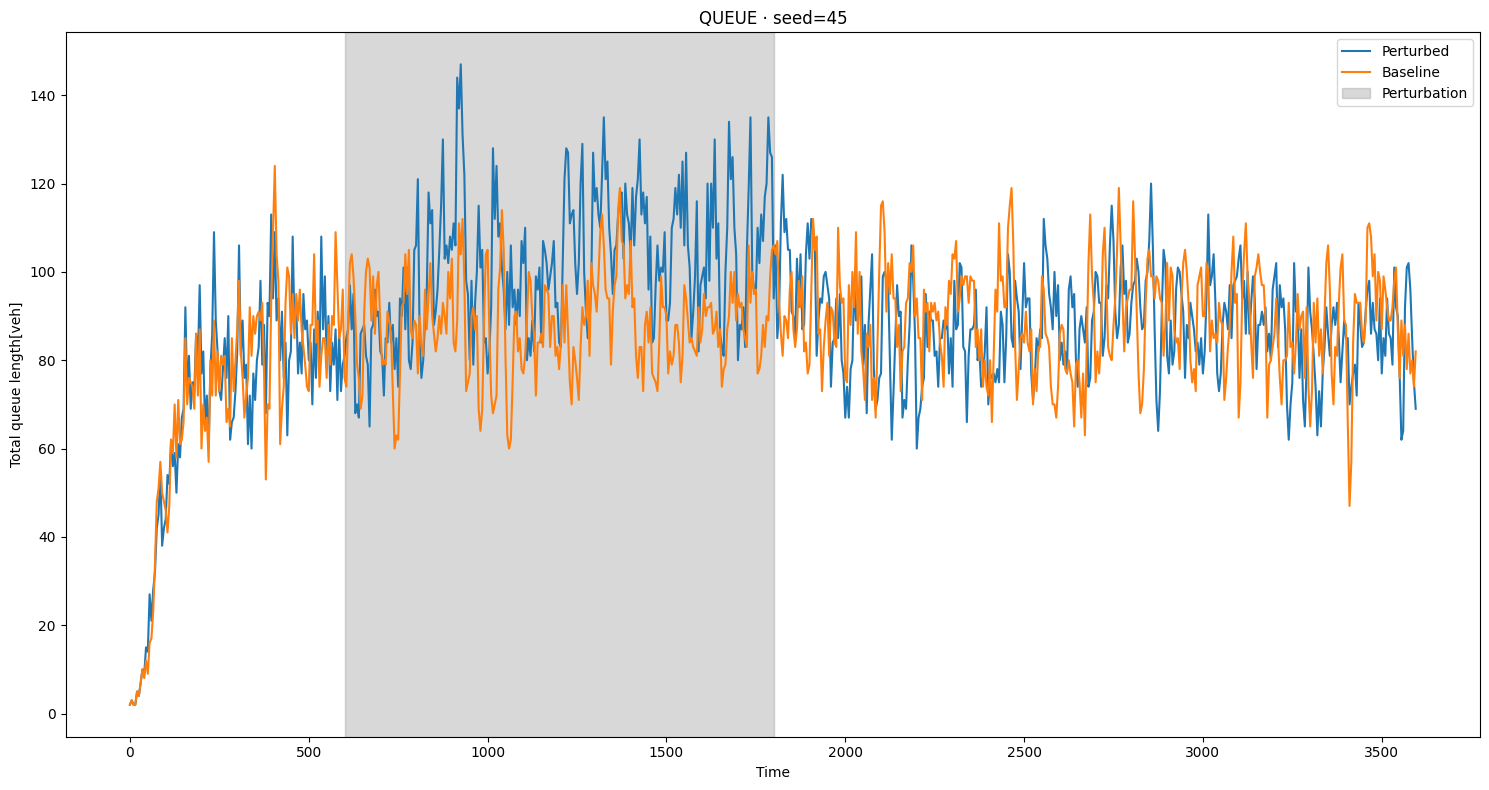

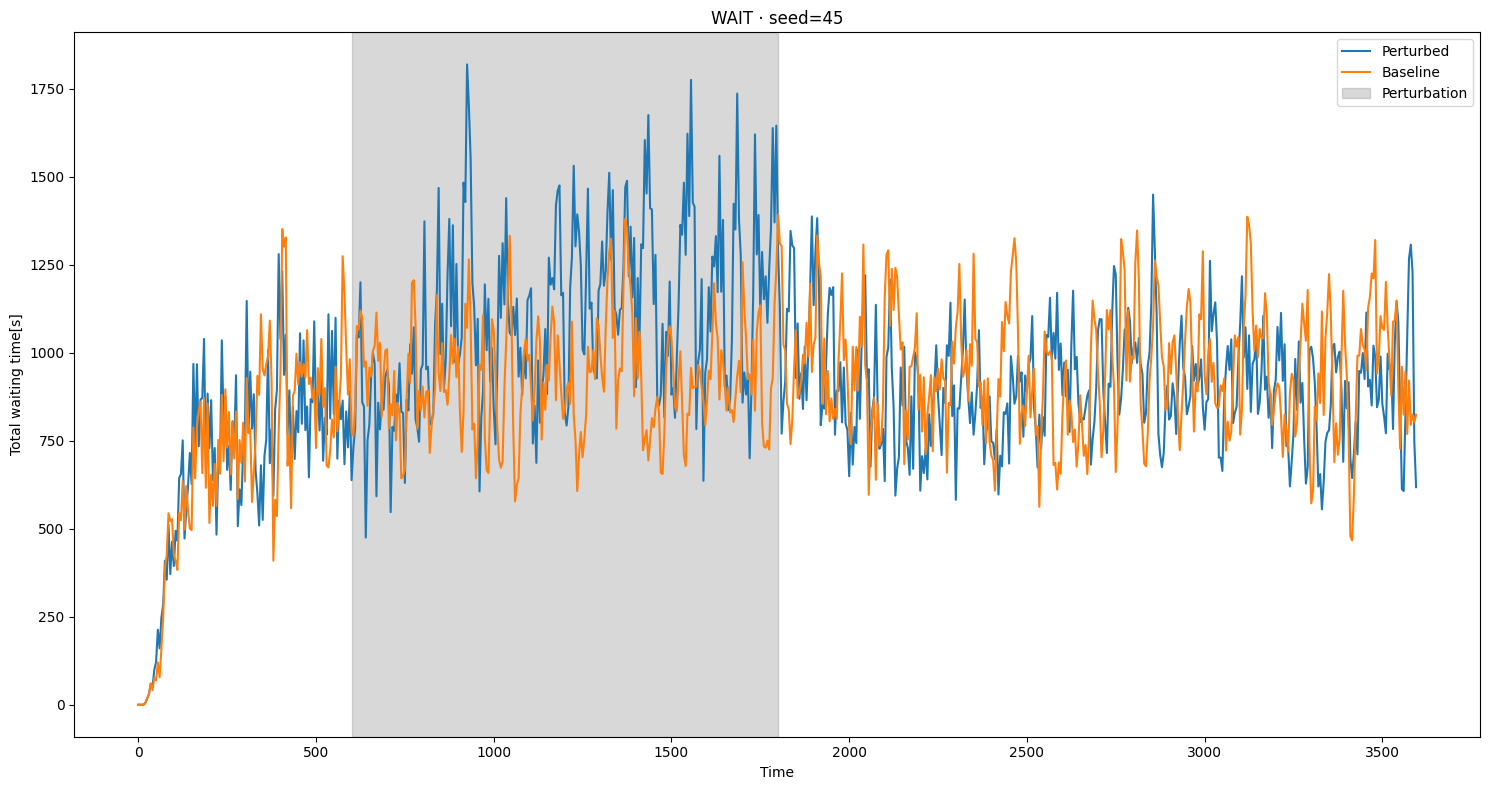

In [58]:
ylabels = {"speed": "Average speed[m/s]", "queue": "Total queue length[veh]", "wait": "Total waiting time[s]"}
for name in SELECTED:
    plot_raw_overlay_simple(
        series_pert[name],
        series_base[name],
        wins,
        ylabel=ylabels.get(name, name),
        title=f"{name.upper()} · seed={SEED}"
    )